# ML Case Study


In [ ]:
!pip install ydata-profiling==4.7.0
!pip install numba==0.59.1

## Load .csv to dataframe

In [1]:
import pandas as pd
import os
import numpy as np

path = "./data"
file_name = "housing_data.csv"

df = pd.read_csv(os.path.join(path, file_name))

## Data overview

Begin with a simple visualization of the dataset

In [2]:
print(df.head())
print(df.info())

     price   area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  3150000   3450         1          1        1      True      False   
1  2275000   3970         1          1        1     False      False   
2  7070000   8880         2          1        1      True      False   
3  6930000  13200         2          1        1      True      False   
4  6419000   6750         2          1        1      True       True   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0     False            False            False        0     False   
1     False            False            False        0     False   
2     False            False             True        1     False   
3      True             True            False        1     False   
4      True            False            False        2      True   

  furnishingstatus  
0        furnished  
1      unfurnished  
2   semi-furnished  
3        furnished  
4        furnished  
<class 'pandas.core.frame.DataFr

Remapping furnishingstatus column to digits. The default format is an issue for ydata_profiling to calculate correlations.

In [3]:
d = {"furnished": "0", "semi-furnished": "1", "unfurnished": "2"}
df['furnishingstatus'] = df['furnishingstatus'].map(d)

In [4]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Data Report")
profile.to_file("data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The report shows that there are no missing values.

One of the highlighted features is a high correlation between price and area, which means that area will mostly determine the price of the house.\
Other notable traits are highly imbalanced columns - bathrooms and hotwaterheating.

Some columns are described as categorical by ydata_profiling due to their low range of possible values (bathrooms, stories, parking), although they may as well be treated as numerical.

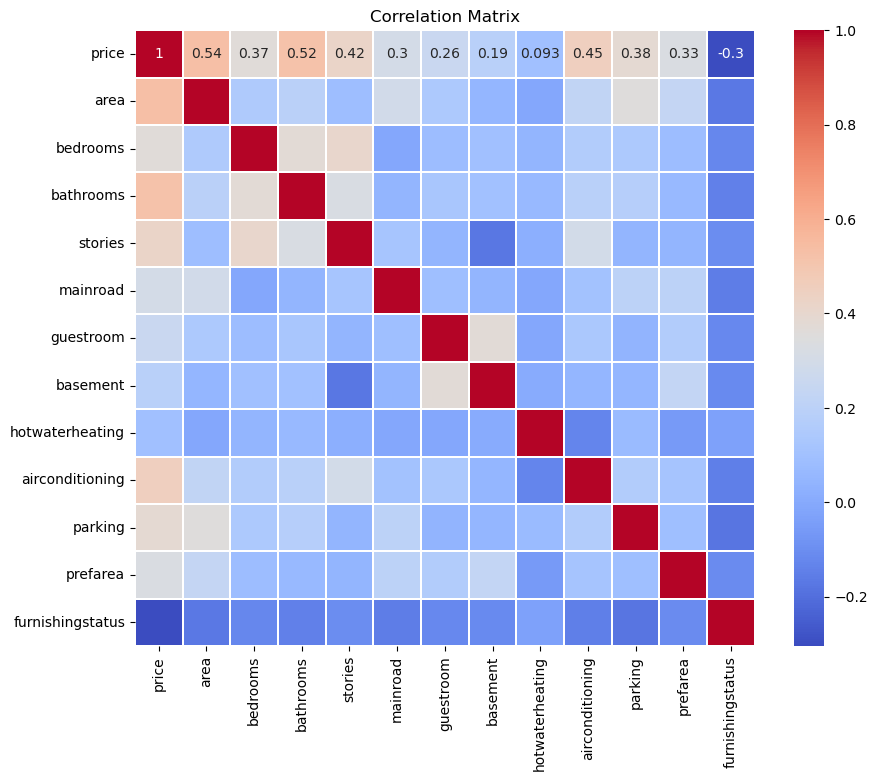

E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


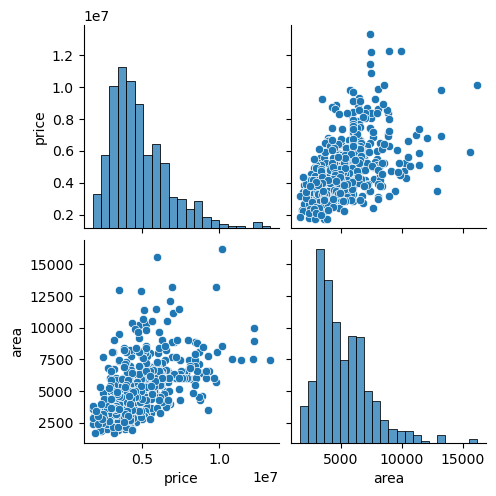

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

columns = ['price', 'area']
sns.pairplot(df[columns])
plt.show()

## Data Cleaning

### Find Outliers

Text(0.5, 1.0, 'parking')

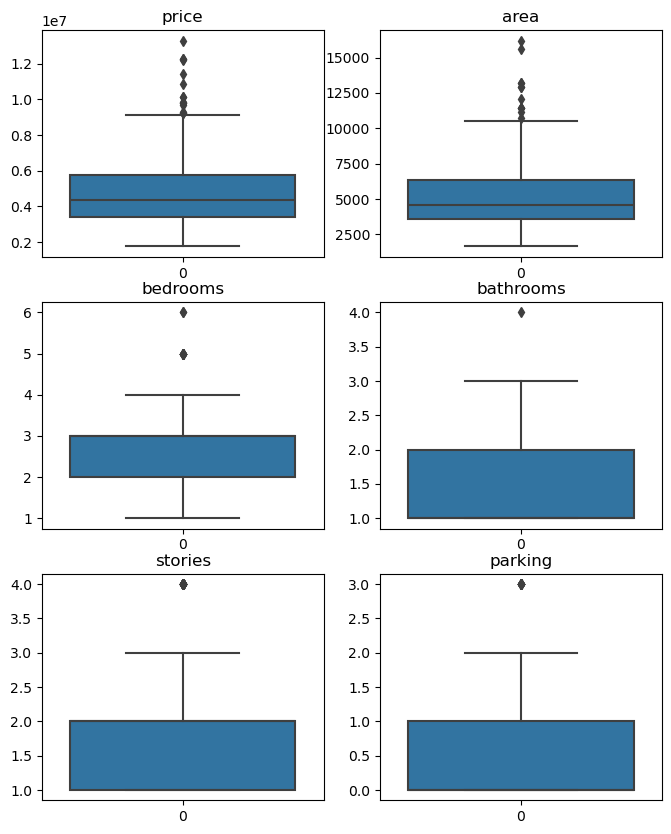

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
sns.boxplot(df['price'],    ax=axes[0, 0])
axes[0, 0].set_title('price')
sns.boxplot(df['area'],     ax=axes[0, 1])
axes[0, 1].set_title('area')
sns.boxplot(df['bedrooms'], ax=axes[1, 0])
axes[1, 0].set_title('bedrooms')
sns.boxplot(df['bathrooms'],ax=axes[1, 1])
axes[1, 1].set_title('bathrooms')
sns.boxplot(df['stories'],  ax=axes[2, 0])
axes[2, 0].set_title('stories')
sns.boxplot(df['parking'],  ax=axes[2, 1])
axes[2, 1].set_title('parking')

As boxplots show, some columns contain visible outliers that, if left unchanged, can negatively affect model performance.


### Perform IQR

In order to address outliers it's necessary to choose an adequate method. Methods such as z-score are adjusted to be used with normal distributions.
Due to bell curves being visibly skewed and the dataset being quite numerous, I chose the Interquartile Range method which is more robust to such data.

In [7]:
import numpy as np
from scipy import stats
columns = ['price','area']

for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5
    df = df[(Q1 - threshold * IQR < df[col]) & (df[col] < Q3 + threshold * IQR)]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 517 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             517 non-null    int64 
 1   area              517 non-null    int64 
 2   bedrooms          517 non-null    int64 
 3   bathrooms         517 non-null    int64 
 4   stories           517 non-null    int64 
 5   mainroad          517 non-null    bool  
 6   guestroom         517 non-null    bool  
 7   basement          517 non-null    bool  
 8   hotwaterheating   517 non-null    bool  
 9   airconditioning   517 non-null    bool  
 10  parking           517 non-null    int64 
 11  prefarea          517 non-null    bool  
 12  furnishingstatus  517 non-null    object
dtypes: bool(6), int64(6), object(1)
memory usage: 35.3+ KB
None


To perform a linear regression it's necessary to take care of boolean and categorical variables.\
Therefore, boolean variables are converted to 0 and 1 values and categorical column gets OneHot encoded.

In [8]:
#Convert boolean values to int64

df = pd.get_dummies(df, columns=['furnishingstatus'])
column_names = {
    'furnishingstatus_0':'furnished',
    'furnishingstatus_1':'semi-furnished',
    'furnishingstatus_2':'unfurnished'
}
df.rename(columns=column_names, inplace=True)

boolean_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnished', 'semi-furnished', 'unfurnished']
df[boolean_cols] = df[boolean_cols].astype('int64')

E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


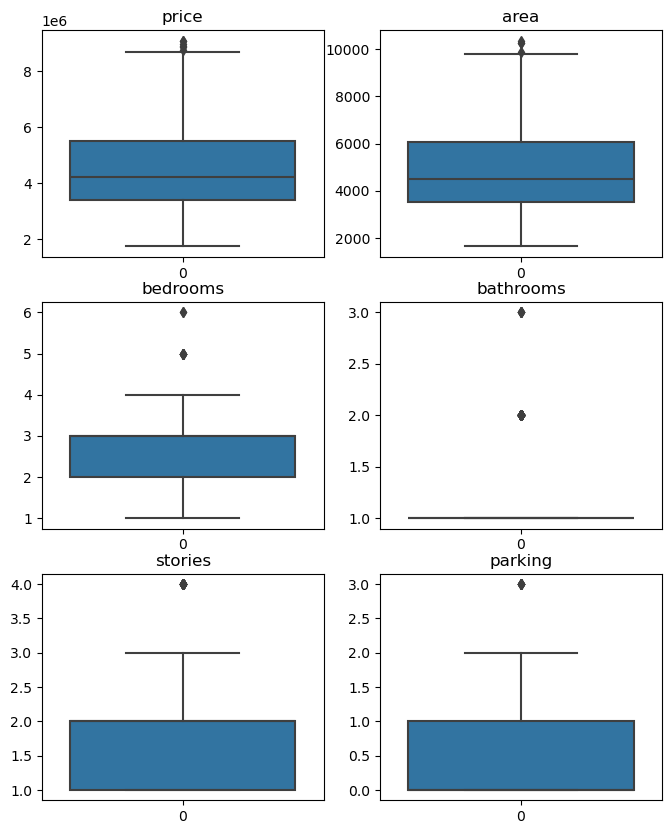

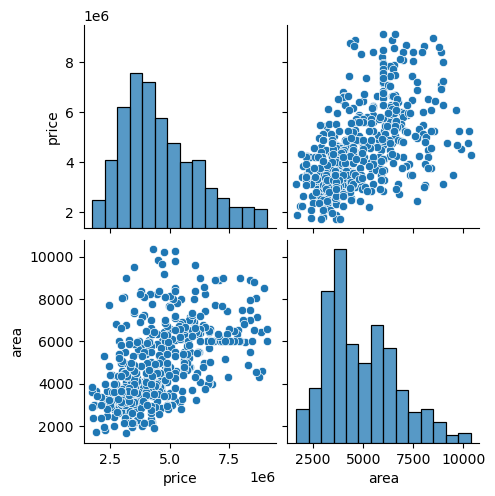

In [9]:
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
sns.boxplot(df['price'],    ax=axes[0, 0])
axes[0, 0].set_title('price')
sns.boxplot(df['area'],     ax=axes[0, 1])
axes[0, 1].set_title('area')
sns.boxplot(df['bedrooms'], ax=axes[1, 0])
axes[1, 0].set_title('bedrooms')
sns.boxplot(df['bathrooms'],ax=axes[1, 1])
axes[1, 1].set_title('bathrooms')
sns.boxplot(df['stories'],  ax=axes[2, 0])
axes[2, 0].set_title('stories')
sns.boxplot(df['parking'],  ax=axes[2, 1])
axes[2, 1].set_title('parking')

columns = ['price', 'area']
sns.pairplot(df[columns])
plt.show()

## Data Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

numeric_columns = X.select_dtypes(include=['int64']).columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_columns),
    ])

## Model Training & Results

To run the regression, I used using Linear Regression, and also two ensemble models - Random Forest and Gradient Boost.
While using Random Forest / Grandient Boost it's usually unnecessary to use standard scaler. I decided to keep it here because since increases model performance slightly in this scenario, which means that all the models presented here use the same preprocessing.

Linear
MAE: 646879.962
RMSE: 867900.727
MAPE: 14.86897252863354
R^2 Score: 0.709


Decision Tree
MAE: 928120.846
RMSE: 1250013.890
MAPE: 20.73356042816639
R^2 Score: 0.397


Random Forest
MAE: 671520.338
RMSE: 879570.999
MAPE: 15.146334879647464
R^2 Score: 0.701


Gradient Boost
MAE: 641956.795
RMSE: 831630.236
MAPE: 14.525773047368537
R^2 Score: 0.733




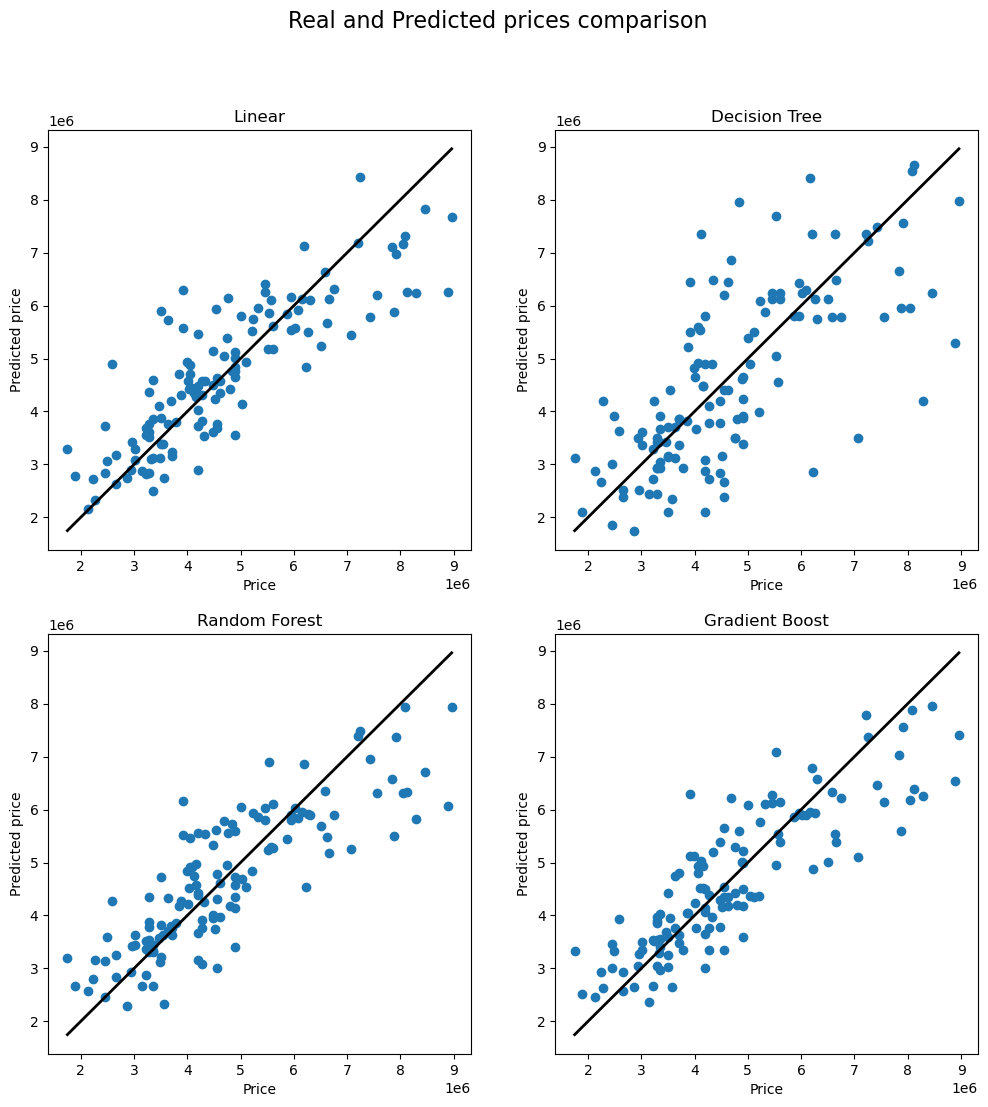

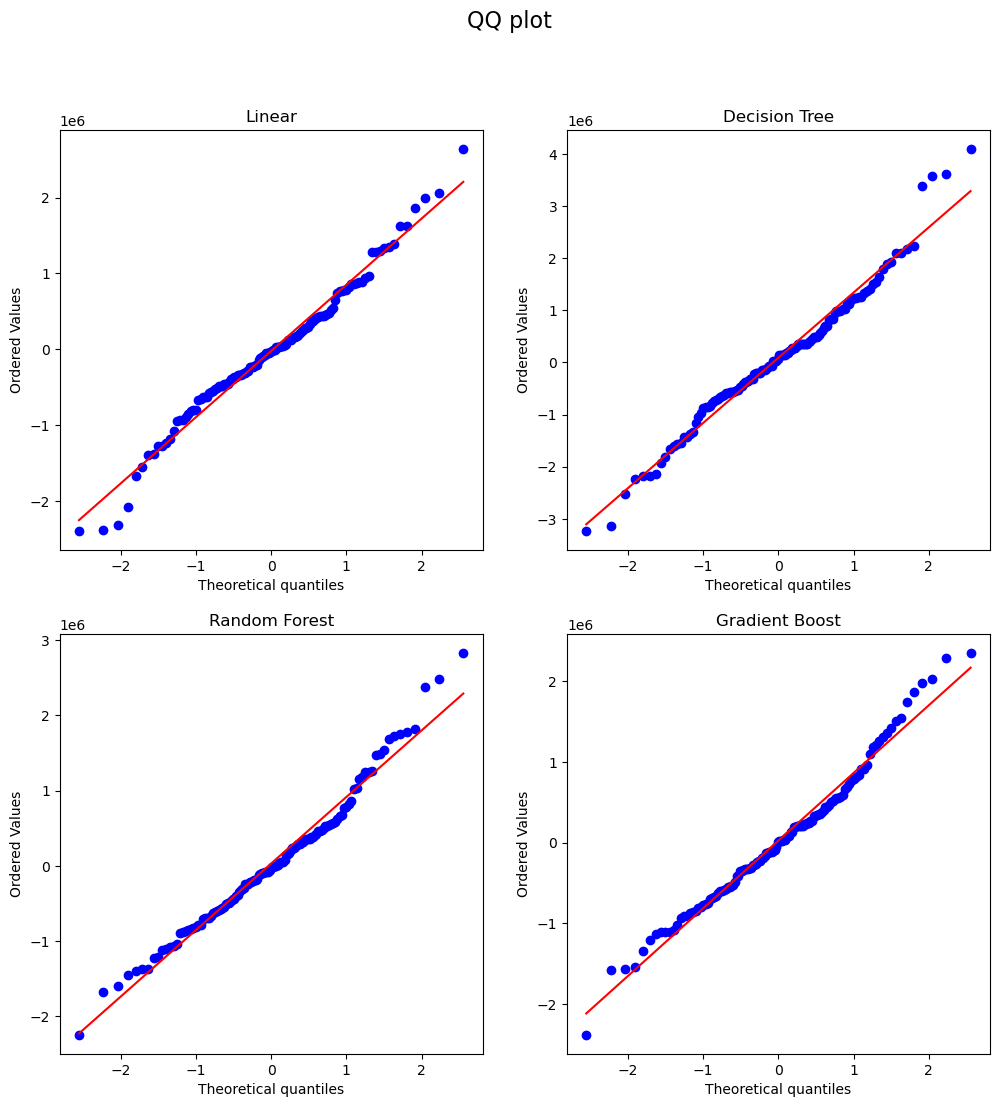

In [11]:
models = {
    'Linear': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boost': GradientBoostingRegressor()
}

# Price and predicted price comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace = 0.2)
fig.suptitle('Real and Predicted prices comparison', fontsize=16)

# QQ plot
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 12))
fig2.subplots_adjust(hspace = 0.2)
fig2.suptitle('QQ plot', fontsize=16)


for i, (name, model) in enumerate(models.items()):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    #Print Evaluation scores
    print(f"{name}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")
    print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100}")
    print(f"R^2 Score: {r2_score(y_test, y_pred):.3f}")
    print("\n")

    # Price and predicted price comparison
    axes[i//2,i%2].scatter(y_test, y_pred)
    axes[i//2,i%2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', lw=2)
    axes[i//2,i%2].set_title(name)
    axes[i//2,i%2].set_xlabel('Price')
    axes[i//2,i%2].set_ylabel('Predicted price')

    # QQ plot
    residuals = y_test - y_pred
    stats.probplot(residuals, dist="norm", plot=axes2[i//2,i%2])
    axes2[i//2,i%2].set_title(name)

The above graphs compare actual and predicted prices. The closer the values are to the straight line, the better.
The QQ plot shows how close the distribution of residuals (difference between real and predicted values) are to the normal distribution.
Having residuals normally distributed is a key assumption in regression, so the closer they are to the straight line, the better the fit.

## Conclusion

Feature importance analysis showed that all variables except for hotwaterheating correlate with house prices, where the area is the most significant one.

While the performance of the presented models (except the single decision tree) is very similar, Gradient Boosting Regressor proved to be the best-performing model, providing the lowest price prediction errors.